In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import random
import matplotlib.pyplot as plt

In [2]:
# Generating mock-up data for the DataFrame
dates = pd.date_range(start='2023-01-01', periods=100)
tickers = [f'Stock_{i}' for i in range(500)]
data = pd.DataFrame(index=pd.MultiIndex.from_product([dates, tickers], names=['Date', 'Ticker']),columns=['Rank', 'Cluster','MarketCap', '63DaysVolatility', 'Fwd_Return'])

# Filling mock-up data
data['Rank'] = data.groupby(level='Date').cumcount() + 1
data['Cluster'] = np.random.choice([1,2,3,4,5], len(data))
data['MarketCap'] = 1000000 * pd.Series({(date, ticker): random.randint(1, 100) for date in dates for ticker in tickers})
data['63DaysVolatility'] = pd.Series({(date, ticker): random.uniform(0.5, 2.5) for date in dates for ticker in tickers})
data['Fwd_Return'] = pd.Series({(date, ticker): random.uniform(-0.05, 0.05) for date in dates for ticker in tickers})

data

Rank  Cluster  MarketCap  63DaysVolatility  Fwd_Return
Date       Ticker                                                           
2023-01-01 Stock_0       1        2   21000000          0.924472   -0.044560
           Stock_1       2        1   27000000          2.213615   -0.023177
           Stock_2       3        2   54000000          1.197263    0.049947
           Stock_3       4        2   48000000          1.301380   -0.011281
           Stock_4       5        3   96000000          0.829059   -0.037409
...                    ...      ...        ...               ...         ...
2023-04-10 Stock_495   496        4   62000000          2.098044    0.002876
           Stock_496   497        1   52000000          1.701161    0.025084
           Stock_497   498        2   58000000          0.916673   -0.004165
           Stock_498   499        1   13000000          1.125598   -0.009131
           Stock_499   500        1    3000000          1.417915   -0.048313

[50000 rows x 5 columns]

In [3]:
def backtest_strategy(data, n, weight_scheme, rebalance_freq):
    returns = []
    start_date = data.index.levels[0][0]  # Start from the first available date
    end_date = start_date + timedelta(days=rebalance_freq)

    while end_date <= data.index.levels[0][-1]:  # Loop until the last available date
        # Group by 'Date' and 'Cluster', then select top 'n' stocks within each group
        selected_stocks = data.loc[start_date].groupby('Cluster', group_keys=False).apply(lambda x: x.nsmallest(n, 'Rank'))

        if weight_scheme == 'equal-weight':
            weights = pd.Series(1 / n, index=selected_stocks.index)
        elif weight_scheme == 'market-cap-weight':
            weights = selected_stocks['MarketCap'] / selected_stocks.groupby('Date')['MarketCap'].transform('sum')
        elif weight_scheme == 'volatility-weight':
            weights = 1 / selected_stocks['63DaysVolatility']
            weights /= weights.groupby('Date').transform('sum')
        else:
            raise ValueError("Invalid weight_scheme. Choose from 'equal-weight', 'market-cap-weight', 'volatility-weight'")

        # Calculate returns for selected stocks over the next period
        next_period_data = data.loc[end_date]
        period_returns = next_period_data.loc[selected_stocks.index, 'Fwd_Return']
        period_return = (weights * period_returns).sum()
        returns.append({
            'Start Date': start_date,
            'End Date': end_date,
            'Number of Stocks': n,
            'Weighting Scheme': weight_scheme,
            'Periodic Return': period_return
        })

        start_date = end_date
        end_date += timedelta(days=rebalance_freq)

    return pd.DataFrame(returns)

In [4]:
# Perform backtesting
df = backtest_strategy(data, 50, 'equal-weight', 10)

df

,Start Date,End Date,Number of Stocks,Weighting Scheme,Periodic Return
0,2023-01-01,2023-01-11,50,equal-weight,0.002117
1,2023-01-11,2023-01-21,50,equal-weight,-0.005146
2,2023-01-21,2023-01-31,50,equal-weight,0.004876
3,2023-01-31,2023-02-10,50,equal-weight,0.007573
4,2023-02-10,2023-02-20,50,equal-weight,-0.003824
5,2023-02-20,2023-03-02,50,equal-weight,-0.018893
6,2023-03-02,2023-03-12,50,equal-weight,-0.005499
7,2023-03-12,2023-03-22,50,equal-weight,0.008744
8,2023-03-22,2023-04-01,50,equal-weight,-0.007898


In [5]:
# Convert date columns to datetime if they are not already
df['Start Date'] = pd.to_datetime(df['Start Date'])
df.rename(columns={'End Date': 'Date'}, inplace=True)  # Rename 'End Date' to 'Date'

# Drop 'Start Date' column
df.drop(columns=['Start Date'], inplace=True)

# Compute cumulative return over time
df['Cumulative Return'] = (1 + df['Periodic Return']).cumprod() - 1

df

,Date,Number of Stocks,Weighting Scheme,Periodic Return,Cumulative Return
0,2023-01-11,50,equal-weight,0.002117,0.002117
1,2023-01-21,50,equal-weight,-0.005146,-0.003039
2,2023-01-31,50,equal-weight,0.004876,0.001822
3,2023-02-10,50,equal-weight,0.007573,0.009410
4,2023-02-20,50,equal-weight,-0.003824,0.005550
5,2023-03-02,50,equal-weight,-0.018893,-0.013448
6,2023-03-12,50,equal-weight,-0.005499,-0.018873
7,2023-03-22,50,equal-weight,0.008744,-0.010294
8,2023-04-01,50,equal-weight,-0.007898,-0.018111


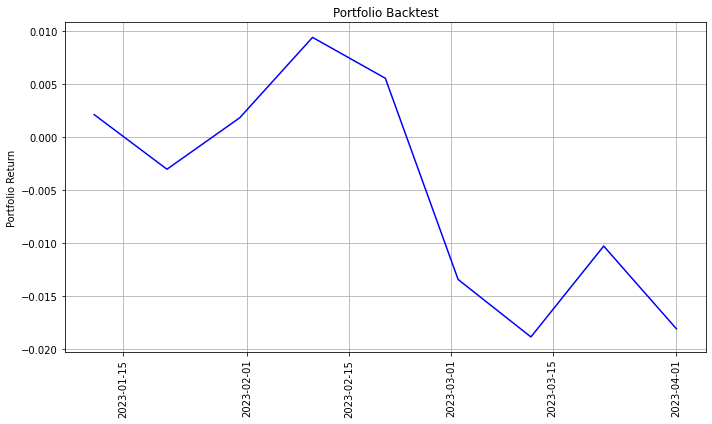

In [10]:
# Plot line chart of cumulative return
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Cumulative Return'], linestyle='-', color='b')
plt.title('Portfolio Backtest')
#plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()